In [1]:
import os
import glob
import json
import numpy as np
import cv2

from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D,Flatten,Dropout,BatchNormalization,Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

In [2]:
train_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train'
test_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test'
valid_path = '/kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid'

# Function to check if a path exists
def check_path(path):
    if os.path.exists(path):
        print(f"Path exists: {path}")
    else:
        print(f"Path does NOT exist: {path}")

# Check the paths
check_path(train_path)
check_path(test_path)
check_path(valid_path)

Path exists: /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/train
Path exists: /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/test
Path exists: /kaggle/input/brain-tumor-image-dataset-semantic-segmentation/valid


In [3]:
train_data=[image for image in os.listdir(train_path)]
test_data=[image for image in os.listdir(test_path)]
valid_data=[image for image in os.listdir(valid_path)]

In [4]:
# Check the number of images in each dataset
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of validation images: {len(valid_data)}")

# Check the shape of some sample images to ensure consistency
sample_image_path = os.path.join(train_path, train_data[0])
sample_image = cv2.imread(sample_image_path)
print(f"Sample image shape: {sample_image.shape}")

Number of training images: 1503
Number of test images: 216
Number of validation images: 430
Sample image shape: (640, 640, 3)


In [5]:
train_annotation=glob.glob(os.path.join(train_path,"*.json"))
test_annotation=glob.glob(os.path.join(test_path,"*.json"))
valid_annotation=glob.glob(os.path.join(valid_path,"*.json"))

In [6]:
train_annotation=json.load(open(train_annotation[0]))
test_annotation=json.load(open(test_annotation[0]))
valid_annotation=json.load(open(valid_annotation[0]))

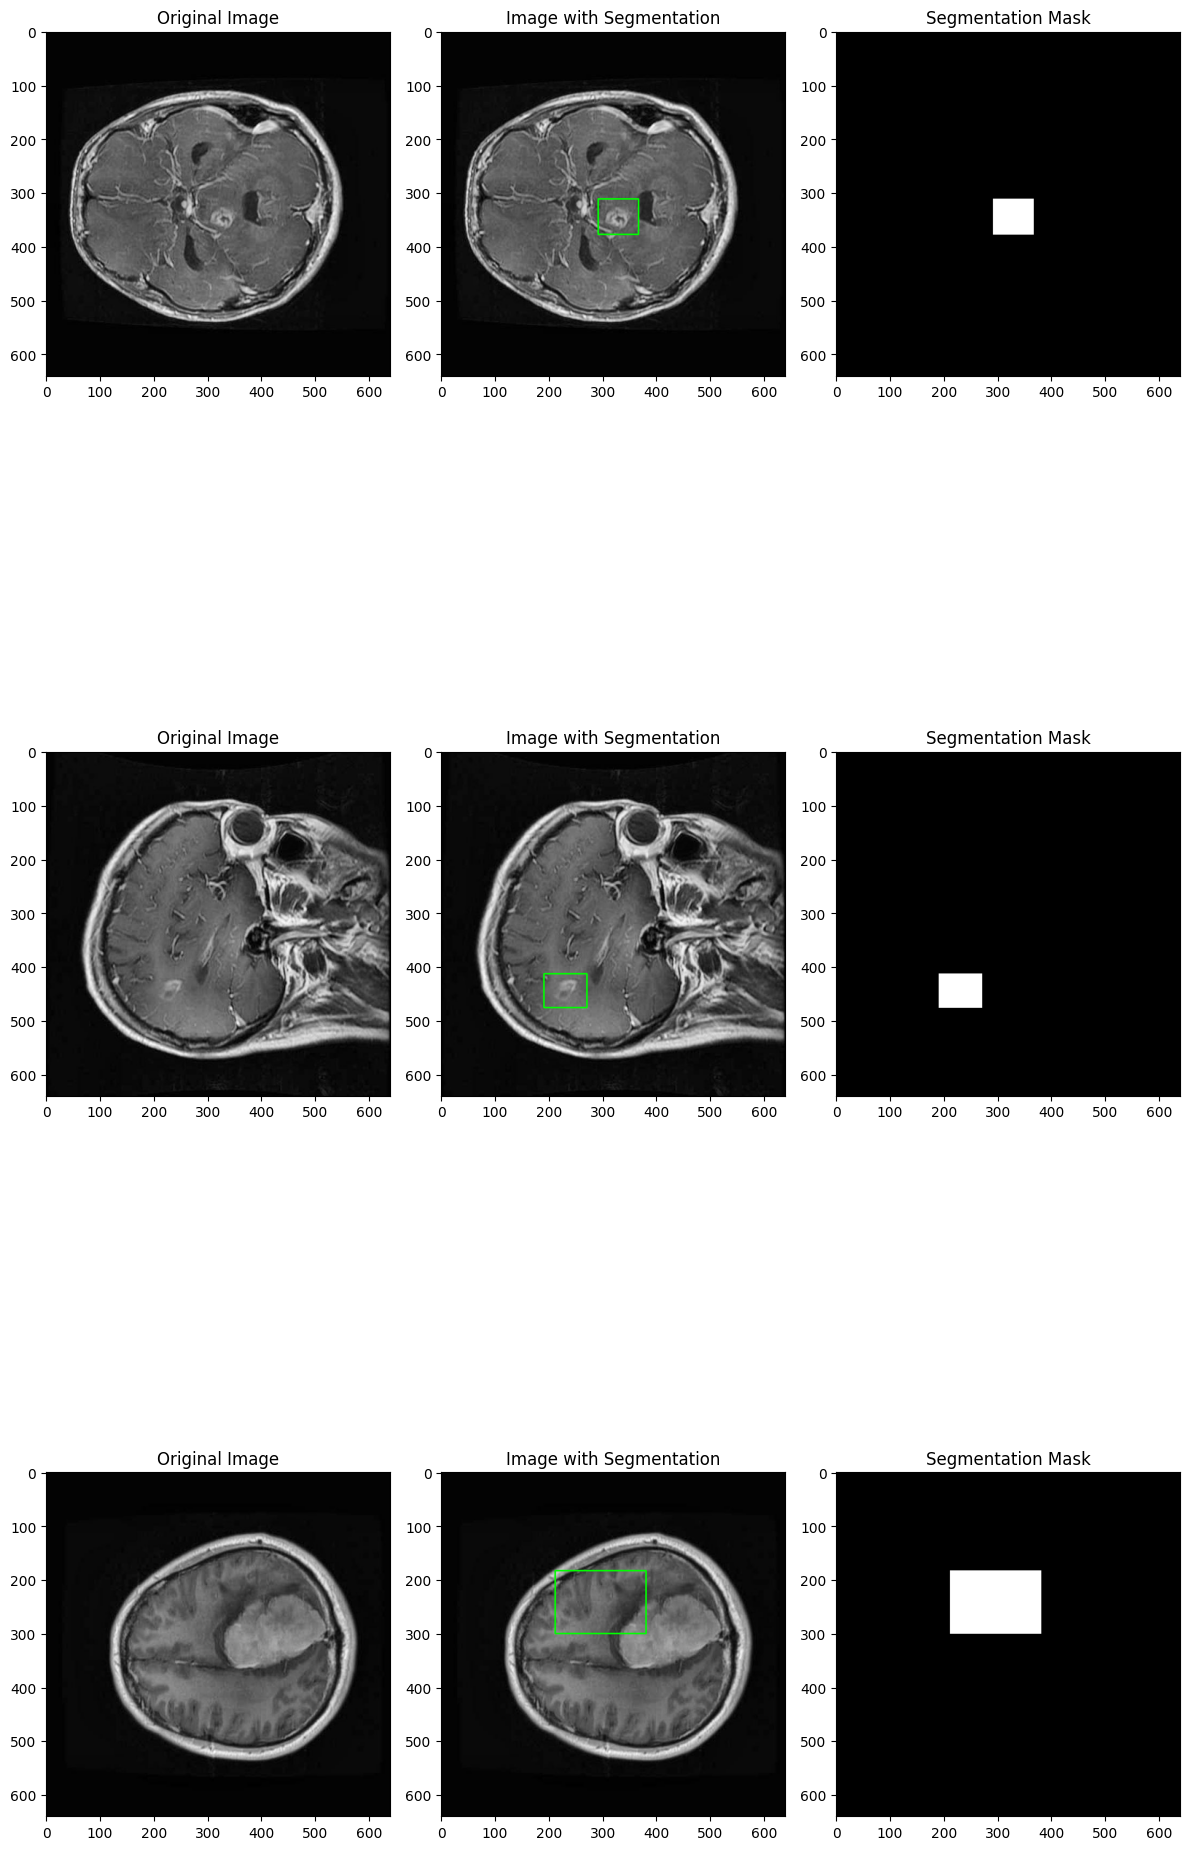

In [7]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

def visualize_random_images(n=3):
    # Select n random images
    indices = np.random.randint(0, len(train_annotation['images']), size=n)

    # Image and Annotation Retrieval:
    images = [train_annotation['images'][i] for i in indices]
    annotations = [train_annotation['annotations'][i] for i in indices]

    j = 1
    plt.figure(figsize=(12, 4 * 2 * n))

    for img, ann in zip(images, annotations):
        # Construct the full image path, assuming 'file_name' key contains the filename
        img_path = os.path.join(train_path, img['file_name'])

        # Load the image
        image = cv2.imread(img_path)

        # Check if the image was loaded properly
        if image is None:
            print(f"Error: Could not load image {img['file_name']}")
            continue

        # Convert image color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Show original image
        plt.subplot(n, 3, j)
        plt.imshow(image)
        plt.title("Original Image")
        j += 1

        # Create masked images from annotations
        segmentation = ann['segmentation'][0]  # Assuming a single polygon for simplicity
        segmentation = np.array(segmentation, dtype=np.int32).reshape(-1, 2)  # Convert to 2D (Nx2)

        # Make a copy of the image to draw on
        img_with_segmentation = image.copy()

        # Draw the segmentation boundary on the image
        cv2.polylines(img_with_segmentation, [segmentation], isClosed=True, color=(0, 255, 0), thickness=2)  # Green color with thickness 2

        # Show the image with segmentation boundary
        plt.subplot(n, 3, j)
        plt.imshow(img_with_segmentation)
        plt.title("Image with Segmentation")
        j += 1

        # Create a mask using the segmentation
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [segmentation], color=1)

        # Show the mask
        plt.subplot(n, 3, j)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmentation Mask")
        j += 1

    # Display all images
    plt.tight_layout()
    plt.show()

visualize_random_images()

In [8]:
# Print segmentation data for debugging
def inspect_segmentation(annotation):
    print("Segmentation data:", annotation['segmentation'])

# Inspect the segmentation for a sample annotation
inspect_segmentation(train_annotation['annotations'][0])

Segmentation data: [[313.75, 238.75, 145, 238.75, 145, 401.25, 313.75, 401.25, 313.75, 238.75]]


In [9]:
# Define the preprocess_image_and_mask function
def preprocess_image_and_mask(image_path, annotation, target_size=(256, 256)):
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, target_size)

    # Create an empty mask
    mask = np.zeros(target_size, dtype=np.uint8)

    # Handle multiple segmentation polygons (if any)
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)  # Convert to 2D array

        # Scale the segmentation coordinates according to the original image size
        scale_x = target_size[1] / original_size[1]  # Scaling based on width
        scale_y = target_size[0] / original_size[0]  # Scaling based on height
        segmentation[:, 0] *= scale_x  # Scale x-coordinates
        segmentation[:, 1] *= scale_y  # Scale y-coordinates

        # Fill the mask with the scaled segmentation
        cv2.fillPoly(mask, [segmentation.astype(np.int32)], color=1)

    return image, mask

# Print image and mask dimensions for verification
def check_dimensions(image, mask):
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

# Test on the first image and mask
sample_image, sample_mask = preprocess_image_and_mask(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)
check_dimensions(sample_image, sample_mask)

Image shape: (256, 256, 3)
Mask shape: (256, 256)


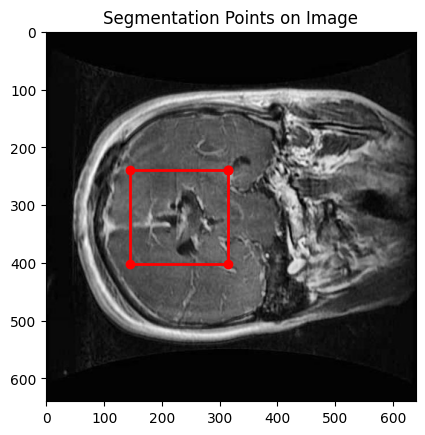

In [10]:
def visualize_segmentation_on_image(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)

    # Overlay segmentation points
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)
        plt.plot(segmentation[:, 0], segmentation[:, 1], 'ro-', linewidth=2)

    plt.title("Segmentation Points on Image")
    plt.show()

# Visualize the segmentation on a sample image
visualize_segmentation_on_image(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)

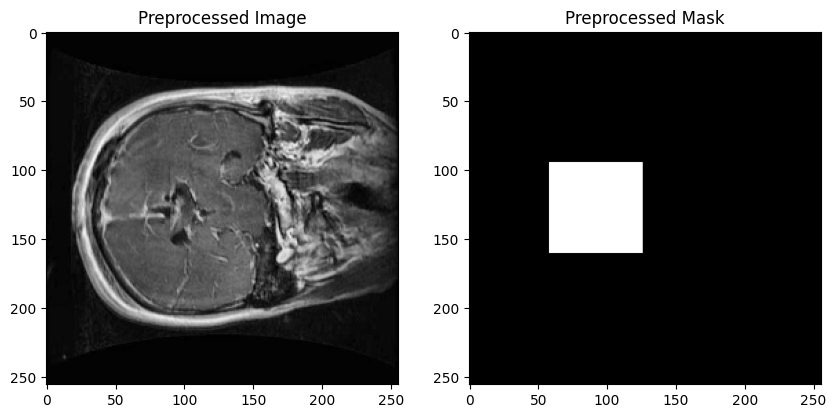

In [11]:
# Updated function to preprocess images and masks
def preprocess_image_and_mask(image_path, annotation, target_size=(256, 256)):
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image.shape[:2]
    image = cv2.resize(image, target_size)

    # Create an empty mask
    mask = np.zeros(target_size, dtype=np.uint8)

    # Handle multiple segmentation polygons (if any)
    for seg in annotation['segmentation']:
        segmentation = np.array(seg, dtype=np.float32).reshape(-1, 2)  # Convert to 2D array

        # Scale the segmentation coordinates according to the original image size
        scale_x = target_size[1] / original_size[1]  # Scaling based on width
        scale_y = target_size[0] / original_size[0]  # Scaling based on height
        segmentation[:, 0] *= scale_x  # Scale x-coordinates
        segmentation[:, 1] *= scale_y  # Scale y-coordinates

        # Fill the mask with the scaled segmentation
        cv2.fillPoly(mask, [segmentation.astype(np.int32)], color=1)

    return image, mask

# Test the updated preprocessing function
sample_image, sample_mask = preprocess_image_and_mask(
    os.path.join(train_path, train_annotation['images'][0]['file_name']),
    train_annotation['annotations'][0]
)

# Display preprocessed image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Preprocessed Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Preprocessed Mask")
plt.show()

In [12]:
# Function to preprocess the entire dataset
def preprocess_dataset(images, annotations, path, target_size=(256, 256)):
    preprocessed_images = []
    preprocessed_masks = []

    for i in range(len(images)):
        image_path = os.path.join(path, images[i]['file_name'])
        image, mask = preprocess_image_and_mask(image_path, annotations[i], target_size)
        preprocessed_images.append(image)
        preprocessed_masks.append(mask)

    # Convert lists to numpy arrays for model input
    preprocessed_images = np.array(preprocessed_images)
    preprocessed_masks = np.array(preprocessed_masks)

    # Normalize images (values between 0 and 1)
    preprocessed_images = preprocessed_images / 255.0

    # Reshape masks for binary classification (adding a channel dimension)
    preprocessed_masks = np.expand_dims(preprocessed_masks, axis=-1)

    return preprocessed_images, preprocessed_masks

# Preprocess training set
X_train, y_train = preprocess_dataset(
    train_annotation['images'],
    train_annotation['annotations'],
    train_path
)

# Preprocess validation set (assuming valid_annotation and valid_path are defined)
X_valid, y_valid = preprocess_dataset(
    valid_annotation['images'],
    valid_annotation['annotations'],
    valid_path
)

# Preprocess test set (assuming test_annotation and test_path are defined)
X_test, y_test = preprocess_dataset(
    test_annotation['images'],
    test_annotation['annotations'],
    test_path
)

# Print the shapes of the preprocessed datasets
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (1502, 256, 256, 3), (1502, 256, 256, 1)
Validation set: (429, 256, 256, 3), (429, 256, 256, 1)
Test set: (215, 256, 256, 3), (215, 256, 256, 1)


In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Attention block definition
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)
    
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    psi = Activation('sigmoid')(psi)
    
    attn_coeff = Multiply()([x, psi])
    return attn_coeff

# Dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.cast(K.flatten(y_true), 'float32')  # Ensure y_true is float32
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss placeholder
def combined_loss(y_true, y_pred):
    return 0.5 * K.binary_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_coefficient(y_true, y_pred))

# Define the Attention U-Net model
def attention_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    p1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    p2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    p3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    p4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder with attention gates
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    attn4 = attention_block(conv4, up6, 512)
    merge6 = concatenate([up6, attn4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    attn3 = attention_block(conv3, up7, 256)
    merge7 = concatenate([up7, attn3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    attn2 = attention_block(conv2, up8, 128)
    merge8 = concatenate([up8, attn2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    attn1 = attention_block(conv1, up9, 64)
    merge9 = concatenate([up9, attn1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the Attention U-Net model
attention_unet_model = attention_unet()

# Compile the model with combined binary crossentropy and dice loss, and dice coefficient as a metric
attention_unet_model.compile(optimizer=Adam(learning_rate=1e-4),
                             loss=combined_loss,
                             metrics=['accuracy', dice_coefficient])

# Display model summary
attention_unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    262,656 │ conv2d_7[0][0]  

 Total params: 31,730,949 (121.04 MB)

 Trainable params: 31,730,949 (121.04 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for images and masks
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Create augmented data generators
image_generator = image_datagen.flow(X_train, batch_size=16, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=42)

# Combine the image and mask generators
train_generator = zip(image_generator, mask_generator)

# For validation, no augmentation is needed, so you can directly use the validation data
val_image_generator = ImageDataGenerator().flow(X_valid, batch_size=16, seed=42)
val_mask_generator = ImageDataGenerator().flow(y_valid, batch_size=16, seed=42)

# Combine validation image and mask generators
val_generator = zip(val_image_generator, val_mask_generator)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/atttenunet_brain_tumor_segmentation.keras', monitor='val_loss', save_best_only=True)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model with the callbacks
history = attention_unet_model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/50


I0000 00:00:1728045497.444376     515 service.cc:145] XLA service 0x7f7658002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728045497.444449     515 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728045536.488656     515 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 135s 931ms/step - accuracy: 0.8982 - dice_coefficient: 0.0659 - loss: 0.7028 - val_accuracy: 0.9619 - val_dice_coefficient: 0.1733 - val_loss: 0.4921 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 426ms/step - accuracy: 0.9626 - dice_coefficient: 0.1794 - loss: 0.4853 - val_accuracy: 0.9619 - val_dice_coefficient: 0.2040 - val_loss: 0.4694 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 425ms/step - accuracy: 0.9622 - dice_coefficient: 0.2186 - loss: 0.4572 - val_accuracy: 0.9352 - val_dice_coefficient: 0.2802 - val_loss: 0.4443 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 425ms/step - accuracy: 0.9465 - dice_coefficient: 0.2701 - loss: 0.4390 - val_accuracy: 0.9560 - val_dice_coefficient: 0.3283 - val_loss: 0.4049 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 424ms/step - accuracy: 0.9488 - dice_coefficient: 0.3032 - loss: 0.4206 - val_accuracy: 0.9514 - val_dice_co

In [16]:
# Evaluate on the test set
test_loss, test_acc, test_dice_coeff = attention_unet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Dice Coefficient: {test_dice_coeff}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9769 - dice_coefficient: 0.6641 - loss: 0.2109
Test Loss: 0.212555393576622
Test Accuracy: 0.9772462248802185
Test Dice Coefficient: 0.6568248867988586


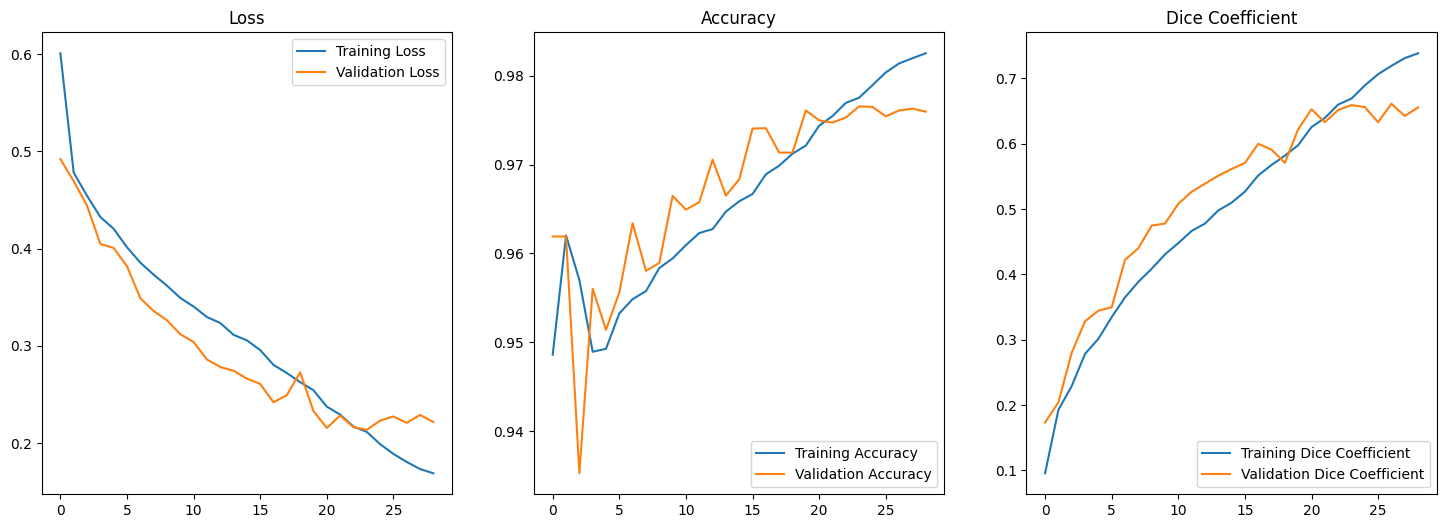

In [17]:
# Plot training & validation loss, accuracy, and dice coefficient
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    # Plot dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.legend(loc='lower right')
    plt.title('Dice Coefficient')

    plt.show()

# Call the function after training completes
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


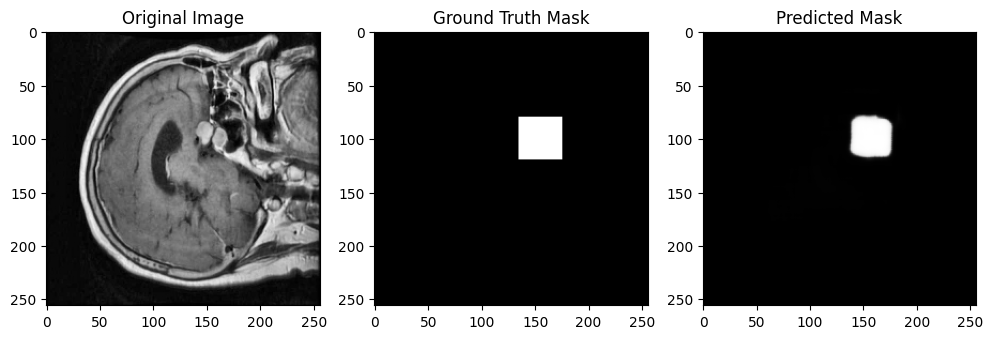

In [19]:
import random

# Predict on a random test image
idx = random.randint(0, len(X_test) - 1)
predicted_mask = attention_unet_model.predict(np.expand_dims(X_test[idx], axis=0))[0]

# Plot the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_test[idx])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.show()